<a id="top"></a>
# Object Detection Tutorial

The following hands on lab is part of the [Intel Edge AI Certification Program](https://software.intel.com/content/www/us/en/develop/tools/devcloud/edge/learn/certification.html).   To ensure you get credit for your work please [register or login here](https://software.intel.com/content/www/us/en/develop/tools/devcloud/edge/learn/certification.html). 

## Prerequisites

This tutorial requires the following:
- All files are present and in the following directory structure:
    - **tutorial_object_detection_ssd.ipynb** - This Jupyter Notebook
    - **labels.txt** - Mapping of numerical labels to text strings
    - **face.jpg** - Test image
    - **car.bmp** - Test image
    - **doc_*.png** - Images used in the documentation
- Optional: URL to user's image or video to run inference on

<br><div class=note><i><b>Note: </b>It is assumed that the server this tutorial is being run on has Jupyter* Notebook, the Intel® Distribution of OpenVINO™ toolkit, and other required libraries already installed.  If you download or copy to a new server, this tutorial may not run.</i></div>  

## Introduction

The purpose of this tutorial is to examine a sample application that was created using the [Intel® Distribution of Open VINO™ toolkit (Open Visual Inference & Neural Network Optimization)](https://software.intel.com/openvino-toolkit).  This tutorial will go step-by-step through the necessary steps to demonstrate object detection on images and video.  Object detection is performed using a pre-trained network and running it using the Intel® Distribution of OpenVINO™ toolkit Inference Engine.  Inference will be executed using the same CPU(s) running this Jupyter* Notebook.

The pre-trained model to be used for object detection is the ["mobilenet-ssd"](https://github.com/chuanqi305/MobileNet-SSD) which we will convert to the necessary Intermediate Representation (IR) files needed by the Inference Engine (Conversion is not covered here, please see the [Intel® Distribution of OpenVINO™ toolkit](https://software.intel.com/en-us/openvino-toolkit) documentation for more details).  The model is capable of detecting 
different objects including: airplane, bicycle, bird, boat, bus, car, cat, dog, horse, person and more (see mobilenet-ssd/labels.txt file for complete list).  

### Key concepts

Before going into the samples in the tutorial steps, first we will go over some key concepts that will be covered in this tutorial.

#### Intel® distribution of OpenVINO™ toolkit overview and terminology

Let us begin with a brief overview of the Intel® Distribution of OpenVINO™ toolkit and what this tutorial will be covering.  The Intel® Distribution of OpenVINO™ toolkit enables the quick deployment of convolutional neural networks (CNN) for heterogeneous execution on Intel® hardware while maximizing performance. This is done using the Intel® Deep Learning Deployment Toolkit (Intel® DLDT) included within the Intel® Distribution of OpenVINO™ toolkit with its main components shown below.

![image alt text](./doc_openvino_overview_image.png)

The basic flow is:

1. Use a tool, such as Caffe*, to create and train a CNN inference model

2. Run the created model through Model Optimizer to produce an optimized Intermediate Representation (IR) stored in files (`.bin` and `.xml`) for use with the Inference Engine

3. The User Application then loads and runs models on devices using the Inference Engine and the IR files  

This tutorial will focus on the last step, the User Application and using the Inference Engine to run a model on a CPU.

##### Using the inference engine

Below is a more detailed view of the User Application and Inference Engine:

![image alt text](./doc_inference_engine_image.png)

The Inference Engine includes a plugin library for each supported device that has been optimized for the Intel® hardware device CPU, GPU, and VPU.  From here, we will use the terms "device" and “plugin” with the assumption that one infers the other (e.g. CPU device infers the CPU plugin and vice versa).  As part of loading the model, the User Application tells the Inference Engine which device to target which in turn loads the associated plugin library to later run on the associated device. The Inference Engine uses “blobs” for all data exchanges, basically arrays in memory arranged according the input and output data of the model.

###### Inference engine API integration flow

Using the inference engine API follows the basic steps outlined briefly below.  The API objects and functions will be seen later in the sample code.

1. Load the plugin

2. Read the model IR

3. Load the model into the plugin

6. Prepare the input

7. Run inference

8. Process the output

More details on the Inference Engine can be found in the [Inference Engine Development Guide](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)

### Input preprocessing

Often, the dimensions of the input data does not match the required dimensions of the input data for the inference model.  A common example is an input video frame.  Before the image may be input to the inference model, the input must be preprocessed to match the required dimensions for the inference model as well as channels (i.e. colors) and batch size (number of images present).  The basic step performed is to resize the frame from the source dimensions to match the required dimensions of the inference model’s input, reorganizing any dimensions as needed.

This tutorial and the many samples in the Intel® Distribution of OpenVINO™ toolkit use OpenCV to perform resizing of input data.  The basic steps performed using OpenCV are:

1.  Resize image dimensions form image to model's input W x H:<br>
`    frame = cv2.resize(image, (w, h))`
   
2. Change data layout from (H x W x C) to (C x H x W)<br>
`    frame = frame.transpose((2, 0, 1))`  

3. Reshape to match input dimensions<br>
`    frame = frame.reshape((n, c, h, w))`

## Sample application

The following sections will guide you through a sample application

### Imports

We begin by importing all of the Python* modules that will be used by the sample code:
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [cv2](https://docs.opencv.org/trunk/) - OpenCV module
- [time](https://docs.python.org/3/library/time.html#module-time) - time tracking module (used for measuring execution time)
- [openvino.inference_engine](https://software.intel.com/en-us/articles/OpenVINO-InferEngine) - the IENetwork and IECore objects
- [matplotlib](https://matplotlib.org/) - pyplot is used for displaying output images

Run the cell below to import Python dependencies needed for displaying the results in this notebook. 

<br><div class=tip><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell.</div>

In [1]:
import os
import cv2
import time
from openvino.inference_engine import IECore
%matplotlib inline
from matplotlib import pyplot as plt
print('Imported Python modules successfully.')

Imported Python modules successfully.


### Create the IR files for the inference model
The Intel® Distribution of OpenVINO™ toolkit includes the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) used to convert and optimize trained models into the Intermediate Representation (IR) model files, and the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) that uses the IR model files to run inference on hardware devices.  The IR model files can be created from trained models from popular frameworks (e.g. Caffe\*, Tensorflow*, etc.). 
The Intel® Distribution of OpenVINO™ toolkit also includes the [Model Downloader](http://docs.openvinotoolkit.org/latest/_tools_downloader_README.html) utility  to download some common inference models from the [Open Model Zoo](https://github.com/opencv/open_model_zoo). 

Optionally: Run the following cell to run the Model Downloader utility with the `--print_all` argument to see all the available inference models.

In [2]:
!downloader.py --name mobilenet-ssd -o raw_model

################|| Downloading mobilenet-ssd ||################

========== Downloading raw_model/public/mobilenet-ssd/mobilenet-ssd.prototxt
... 100%, 28 KB, 45182 KB/s, 0 seconds passed

========== Downloading raw_model/public/mobilenet-ssd/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 13166 KB/s, 1 seconds passed



Now, use converter.py to converts the models that are not in the Inference Engine IR format into that format using Model Optimizer.

In [3]:
!converter.py --name mobilenet-ssd -d raw_model -o model

========== Converting mobilenet-ssd to IR (FP16)
Conversion command: /usr/bin/python3 -m mo --framework=caffe --data_type=FP16 --output_dir=model/public/mobilenet-ssd/FP16 --model_name=mobilenet-ssd '--input_shape=[1,3,300,300]' --input=data '--mean_values=data[127.5,127.5,127.5]' '--scale_values=data[127.5]' --output=detection_out --input_model=raw_model/public/mobilenet-ssd/mobilenet-ssd.caffemodel --input_proto=raw_model/public/mobilenet-ssd/mobilenet-ssd.prototxt

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u115517/Reference-samples/iot-devcloud/openvino-dev-latest/certification-program/English/object_detection/raw_model/public/mobilenet-ssd/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u115517/Reference-samples/iot-devcloud/openvino-dev-latest/certification-program/English/object_detection/model/public/mobilenet-ssd/FP16
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Inpu

### Configuration
Here we will create and set the following configuration parameters used by the sample:  
* **model_xml** - Path to the .xml IR file of the trained model to use for inference
* **model_bin** - Path to the .bin IR file of the trained model to use for inference (derived from *model_xml*)
* **input_path** - Path to input image
* **device** - Specify the target device to infer on,  CPU, GPU, FPGA, or MYRIAD is acceptable, however the device must be present.  For this tutorial we use "CPU" which is known to be present.
* **labels_path** - Path to labels mapping file used to map outputted integers to strings (e.g. 7="car")
* **prob_threshold** - Probability threshold for filtering detection results

We will set all parameters here only once except for `input_path` which we will change later to point to different images and video.

In [4]:
# model IR files
model_xml = "model/public/mobilenet-ssd/FP32/mobilenet-ssd.xml"
model_bin = os.path.splitext(model_xml)[0] + ".bin" # create IR .bin filename from path to IR .xml file

# input image file
input_path = "car.bmp"

# CPU extension library to use
cpu_extension_path = os.path.expanduser("~")+"/inference_engine_samples/intel64/Release/lib/libcpu_extension.so"

# device to use
device = "CPU"

# output labels 
labels_path = "labels.txt"

# minimum probability threshold to detect an object
prob_threshold = 0.5

print("Configuration parameters settings:"
     "\n\tmodel_xml=", model_xml,
      "\n\tmodel_bin=", model_bin,
      "\n\tinput_path=", input_path,
      "\n\tdevice=", device, 
      "\n\tlabels_path=", labels_path, 
      "\n\tprob_threshold=", prob_threshold)

Configuration parameters settings:
	model_xml= model/public/mobilenet-ssd/FP32/mobilenet-ssd.xml 
	model_bin= model/public/mobilenet-ssd/FP32/mobilenet-ssd.bin 
	input_path= car.bmp 
	device= CPU 
	labels_path= labels.txt 
	prob_threshold= 0.5


### Create inference engine instance

Next we create the Inference Engine instance to be used by our application.


In [5]:
# create Inference Engine instance
ie = IECore()
print("An Inference Engine object has been created")

An Inference Engine object has been created


### Create network

Here we create an IENetwork object and load the model's IR files into it. After loading the model, we check to make sure that all the model's layers are supported by the plugin we will use. We also check to make sure that the model's input and output are as expected for later when we run inference.

In [6]:
# load network from IR files
net = ie.read_network(model=model_xml, weights=model_bin)
print("Loaded model IR files [",model_bin,"] and [", model_xml, "]\n")

# check to make sue that the model's input and output are what is expected
assert len(net.input_info.keys()) == 1, \
    "ERROR: This sample supports only single input topologies"
assert len(net.outputs) == 1, \
    "ERROR: This sample supports only single output topologies"
print("SUCCESS: Model IR files have been loaded and verified")

Loaded model IR files [ model/public/mobilenet-ssd/FP32/mobilenet-ssd.bin ] and [ model/public/mobilenet-ssd/FP32/mobilenet-ssd.xml ]

SUCCESS: Model IR files have been loaded and verified


### Load model

Here we load the model network into the plugin so that we may run inference.  `exec_net` will be used later to actually run inference.  After loading, we store the names of the input (`input_blob`) and output (`output_blob`) blobs to use when accessing the input and output blobs of the model.  Lastly, we store the model's input dimensions into the following variables:
- `n` = input batch size
- `c` = number of input channels (here 1 channel per color R,G, and B)
- `h` = input height
- `w` = input width

In [8]:
# load the model into the Inference Engine for our device
exec_net = ie.load_network(network=net, num_requests=2, device_name=device)

# store name of input and output blobs
input_blob = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

# read the input's dimensions: n=batch size, c=number of channels, h=height, w=width
n, c, h, w = net.input_info[input_blob].input_data.shape
print("Loaded model into Inference Engine for device:", device, 
      "\nModel input dimensions: n=",n,", c=",c,", h=",h,", w=",w)
print(input_blob, output_blob)

Loaded model into Inference Engine for device: CPU 
Model input dimensions: n= 1 , c= 3 , h= 300 , w= 300
data detection_out


### Load labels

For each detected object, the output from the model will include an integer to indicate which type (e.g. car, person, etc.) of trained object has been detected.  To translate the integer into a more readable text string, a label mapping file may be used.  The label mapping file is simply a text file of the format "n: string" (e.g. "7: car" for 7="car") that is loaded into a lookup table to be used later while labeling detected objects.

Here, if the `labels_path` variable has been set to point to a label mapping file, we open the file and load the labels into the variable `labels_map`.

In [9]:
labels_map = None
# if labels points to a label mapping file, then load the file into labels_map
print(labels_path)
if os.path.isfile(labels_path):
    with open(labels_path, 'r') as f:
        labels_map = [x.split(sep=' ', maxsplit=1)[-1].strip() for x in f]
    print("Loaded label mapping file [",labels_path,"]")
else:
    print("No label mapping file has been loaded, only numbers will be used",
          " for detected object labels")

labels.txt
Loaded label mapping file [ labels.txt ]


### Prepare input

Here we read and then prepare the input image by resizing and re-arranging its dimensions according to the model's input dimensions. We define the functions `loadInputImage()` and `resizeInputImage()` for the operations so that we may reuse them again later in the tutorial.

Loaded input image [ car.bmp ], resolution= 749.0 w x  637.0 h
Resized input image from (637, 749) to (300, 300)
Input image:


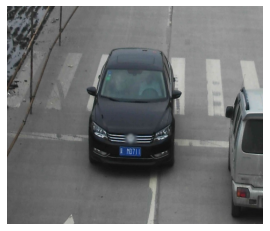

In [10]:
# define function to load an input image
def loadInputImage(input_path, verbose = True):
    # globals to store input width and height
    global input_w, input_h
    
    # use OpenCV to load the input image
    cap = cv2.VideoCapture(input_path) 
    
    # store input width and height
    input_w = cap.get(3)
    input_h = cap.get(4)
    if verbose: print("Loaded input image [",input_path,"], resolution=", input_w, "w x ",input_h,"h")

    # load the input image
    ret, image = cap.read()
    del cap
    return image

# define function for resizing input image
def resizeInputImage(image, verbose = True):
    # resize image dimensions form image to model's input w x h
    in_frame = cv2.resize(image, (w, h))
    # Change data layout from HWC to CHW
    in_frame = in_frame.transpose((2, 0, 1))  
    # reshape to input dimensions
    in_frame = in_frame.reshape((n, c, h, w))
    if verbose: print("Resized input image from {} to {}".format(image.shape[:-1], (h, w)))
    return in_frame

# load image
image = loadInputImage(input_path)

# resize the input image
in_frame = resizeInputImage(image)

# display input image
print("Input image:")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Run inference

Now that we have the input image in the correct format for the model, we now run inference on the input image that was previously set to `./car.bmp`:
<img src="car.bmp" style="width:150px"/>

In [11]:
# save start time
inf_start = time.time()

# run inference
res = exec_net.infer(inputs={input_blob: in_frame})   

# calculate time from start until now
inf_time = time.time() - inf_start
print("Inference complete, run time: {:.3f} ms".format(inf_time * 1000))

Inference complete, run time: 55.170 ms


### Process results
Now we parse the inference results and for each object detected draw boxes with text annotations on image.  We define the function `processResults()` so that we may use it again later in the tutorial to process results.

`res` is set to the output of the inference model which is an array of results, with one element for each detected object.  We loop through `res` setting `obj` to hold the results for each detected object which appear in `obj` as:
- `obj[1]` = Class ID (type of object detected)
- `obj[2]` = Probability of detected object
- `obj[3]` = Lower x coordinate of detected object 
- `obj[4]` = Lower y coordinate of detected object
- `obj[5]` = Upper x coordinate of detected object
- `obj[6]` = Upper y coordinate of detected object

In [12]:
# create function to process inference results
def processResults(result):
    # get output results
    res = result[output_blob]
    
    # loop through all possible results
    for obj in res[0][0]:
        # If probability is more than specified threshold, draw and label box 
        if obj[2] > prob_threshold:
            # get coordinates of box containing detected object
            xmin = int(obj[3] * input_w)
            ymin = int(obj[4] * input_h)
            xmax = int(obj[5] * input_w)
            ymax = int(obj[6] * input_h)
            
            # get type of object detected
            class_id = int(obj[1])
            
            # Draw box and label for detected object
            color = (min(class_id * 12.5, 255), 255, 255)
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 4)
            det_label = labels_map[class_id] if labels_map else str(class_id)
            cv2.putText(image, det_label + ' ' + str(round(obj[2] * 100, 1)) + ' %', (xmin, ymin - 7),
                        cv2.FONT_HERSHEY_COMPLEX, 1, color, 2)

processResults(res)
print("Processed inference output results.")

Processed inference output results.


### Display results
Now that the results from inference have been processed, we display the image to see what has been detected.  

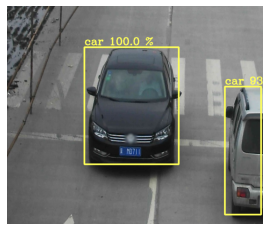

In [13]:
# convert colors BGR -> RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# disable axis display, then display image
plt.axis("off")
plt.imshow(image)

## Exercise #1: Run a different image
Now that we have seen all the steps, let us run them again on a different image.  We also define *inferImage()* to combine the input processing, inference, and results processing so that we may use it again later in the tutorial.

Loaded input image [ face.jpg ], resolution= 1180.0 w x  787.0 h
Resized input image from (787, 1180) to (300, 300)


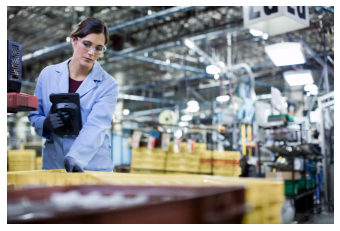

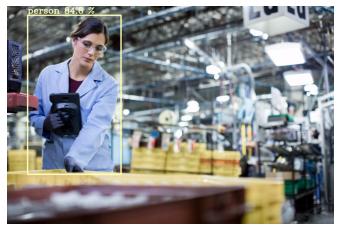

In [14]:
# define function to prepare input, run inference, and process inference results
def inferImage(image, verbose = True):
    # prepare input
    in_frame = resizeInputImage(image, verbose)

    # run inference
    res = exec_net.infer(inputs={input_blob: in_frame})   

    # process inference results 
    processResults(res)

# set path to different input image
input_path="face.jpg"

# load input image
image = loadInputImage(input_path)

# display input image
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# infer image
inferImage(image)

# display image with inference results
# convert colors BGR -> RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# create new figure, disable axis display, then display image
plt.figure()
plt.axis("off")
plt.imshow(image)

## Exercise #2: (Optional) Run your own image

Here you may run any image you would like by setting the `input_path` variable which may be set to a local file or URL.  A sample URL is provided as an example.

Loaded input image [ https://github.com/chuanqi305/MobileNet-SSD/raw/master/images/004545.jpg ], resolution= 500.0 w x  375.0 h
Resized input image from (375, 500) to (300, 300)


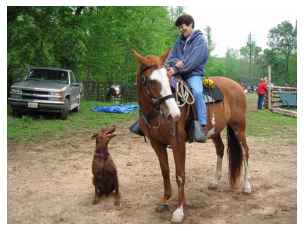

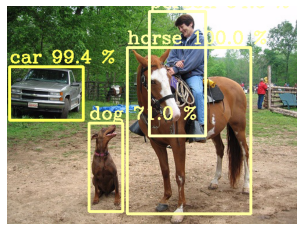

In [15]:
# input_path may be set to a local file or URL
input_path="https://github.com/chuanqi305/MobileNet-SSD/raw/master/images/004545.jpg"

# load input image
image = loadInputImage(input_path)

# display input image
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# infer image
inferImage(image)

# display image with inference results
# convert colors BGR -> RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# create figure, disable axis display, then display image
plt.figure()
plt.axis("off")
plt.imshow(image)

## Exercise #3: Running inference on video
We have seen how to run individual images, now how do we do video?  To run inference on video is much the same as for a single image except that a loop is necessary to process all the frames in the video.  In the code below, we use the same method of loading a video as we had for an image, but now include the while-loop to keep reading images until `cap.isOpened()` returns false or `cap.read()` sets `ret` to false:
```python
while cap.isOpened():
    # read video frame
    ret, im = cap.read()
   
    # break if no more video frames
    if not ret:
        break  
    ...
```

In [16]:
# input_path may be set to local file or URL 
input_path = "cars.mp4"

print("Loading video [",input_path,"]")

# use OpenCV to load the input image
cap = cv2.VideoCapture(input_path) 
scale = 0.5
out_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) * scale)
out_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) * scale)
input_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
input_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_name = 'output.mp4'
frame = 20.0
vw = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'avc1'), frame, (out_width, out_height), True)

while cap.isOpened():
    # read video frame
    ret, image = cap.read()
   
    # break if no more video frames
    if not ret:
        break  
    
    inferImage(image, False)
    image = cv2.resize(image, (out_width, out_height))
    vw.write(image)

cap.release()
vw.release()
print("Done.")

Loading video [ cars.mp4 ]
Done.


Let's take a look at the output video.

In [17]:
from IPython.display import Video
Video(video_name)

## Exercise #4: (Optional) Run your own video
If you would like to see inference run on your own video, you may do so by first setting `input_path` to a local file or URL and then re-executing the cell above.  For example, you could use this video: https://github.com/intel-iot-devkit/sample-videos/raw/master/person-bicycle-car-detection.mp4 by replacing the `input_path="..."` line above with the line:

```python
input_path="https://github.com/intel-iot-devkit/sample-videos/raw/master/person-bicycle-car-detection.mp4"
```


<br><div class=note><i><b>Note: </b>There are more videos available to choose from at: https://github.com/intel-iot-devkit/sample-videos/</i></div>

# To receive credit please run the cell below

In [18]:
job_id = !qsub EAICertv1.0-Completed-Industrial-Worker-Safety-Object-Detection.sh -l nodes=1:idc001skl
print(job_id[0])
!/bin/echo "##" $(whoami) is running Edge_Certification Module2 -- Completed-Industrial-Worker-Safety-Object-Detection sample - 1 of 1

296814.v-qsvr-1.devcloud-edge
## u115517 is running Edge_Certification Module2 -- Completed-Industrial-Worker-Safety-Object-Detection sample - 1 of 1


## Cleanup

Now that we are done running the sample, we clean up by deleting objects before exiting.

In [19]:
del exec_net
del net
del ie

print("Resource objects removed")

Resource objects removed


## Next steps

- [More Jupyter Notebook Tutorials](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/learn/tutorials.html?s=Newest) - additional sample application Jupyter* Notebook tutorials
- [Jupyter* Notebook Samples](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/build/sample-apps.html?s=Newest) - sample applications
- [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit) - learn more about the tools and use of the Intel® Distribution of OpenVINO™ toolkit for implementing inference on the edge

## About this notebook

For technical support, please see the [Intel® DevCloud Forums](https://software.intel.com/en-us/forums/intel-devcloud-for-edge)

<p style=background-color:#0071C5;color:white;padding:0.5em;display:table-cell;width:100pc;vertical-align:middle>
<img style=float:right src="https://devcloud.intel.com/edge/static/images/svg/IDZ_logo.svg" alt="Intel DevCloud logo" width="150px"/>
<a style=color:white>Intel® DevCloud for the Edge</a><br>   
<a style=color:white href="#top">Top of Page</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Intel-DevCloud-for-the-Edge-Usage-Agreement.pdf">Usage Agreement (Intel)</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Colfax_Cloud_Service_Terms_v1.3.pdf">Service Terms (Colfax)</a>
</p>
